In [ ]:
# # LSTM Model for Dengue Prediction
# This notebook implements an LSTM (Long Short-Term Memory) neural network for the Dengue prediction task.

# ## Approach
# 1. **Preprocessing**: Standard cleaning and forward filling.
# 2. **Feature Engineering**: Rolling mean and standard deviation features are added. Explicit lag features are omitted as the LSTM sequence input handles temporal history.
# 3. **Scaling**: StandardScaler
# 4. **Sequencing**: Data is transformed into sequences of length `SEQ_LEN` (e.g., 20 weeks) to feed into the LSTM.
# 5. **Model**: A stacked LSTM architecture with Dropout for regularization.

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

WORKING_DIR = 'C:/Users/malik.kalembasi/OneDrive - Odine Solutions/Desktop/itu/machine_learning/term_project'
os.chdir(WORKING_DIR)
DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

print("Libraries imported and environment set.")

c:\term_project\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Libraries imported and environment set.


In [3]:
# HYPERPARAMETERS

TEST_SPLIT_RATIO = 0.2
LAG_WEEKS = [4, 8, 12]
ROLLING_WEEKS = [4, 8, 12]
PEARSON_PRUNE_THRESHOLD = 0.95
SEQ_LEN = 20  # Number of weeks in each input sequence
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
PATIENCE = 10  # Early stopping patience

In [4]:
# LOAD DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan features:", sj_train_features.shape)
print("Iquitos features:", iq_train_features.shape)

# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill)
    df = df.ffill()
    
    return df

# Apply to San Juan and Iquitos
sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed:", sj_train.shape)
print("Iquitos Preprocessed:", iq_train.shape)

San Juan features: (936, 21)
Iquitos features: (520, 21)
San Juan Preprocessed: (936, 23)
Iquitos Preprocessed: (520, 23)


In [5]:
# FEATURE ENGINEERING

def add_engineered_features(df, rolling_weeks=ROLLING_WEEKS, lag_weeks=LAG_WEEKS):
    """
    Adds rolling mean/std and lag features.
    """
    df_eng = df.copy()
    # Select numeric feature columns (exclude target and time identifiers if needed)
    # We keep year/weekofyear as features as they capture seasonality
    feature_cols = [c for c in df.columns if c not in ['total_cases']]
    
    new_features = []
    for col in feature_cols:
        # Skip year/weekofyear for rolling stats if desired, but they are monotonic/cyclic so maybe skip
        if col in ['year', 'weekofyear']:
            continue
            
        # Rolling features
        for window in rolling_weeks:
            rolling = df_eng[col].rolling(window=window)
            new_features.append(rolling.mean().rename(f'{col}_mean_{window}'))
            new_features.append(rolling.std().rename(f'{col}_std_{window}'))
            
        # Lag features
        for lag in lag_weeks:
            new_features.append(df_eng[col].shift(lag).rename(f'{col}_lag_{lag}'))
    
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
        
    # Drop NaNs created by rolling/lags
    df_eng.dropna(inplace=True)
    return df_eng

def remove_collinear_features(df, threshold):
    """
    Removes features that are highly correlated with each other.
    Keeps the first feature and drops the subsequent highly correlated ones.
    """
    df_clean = df.copy()
    
    # Calculate correlation matrix
    # Only use feature columns (exclude target)
    if 'total_cases' in df_clean.columns:
        features = df_clean.drop(columns=['total_cases'])
    else:
        features = df_clean
        
    corr_matrix = features.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Dropping {len(to_drop)} features due to collinearity > {threshold}")
    df_clean.drop(columns=to_drop, inplace=True)
    
    return df_clean, to_drop

print("Adding engineered features (rolling + lags)...")
sj_train_eng = add_engineered_features(sj_train)
iq_train_eng = add_engineered_features(iq_train)

print("Removing collinear features...")
sj_train_eng, sj_dropped = remove_collinear_features(sj_train_eng, PEARSON_PRUNE_THRESHOLD)
iq_train_eng, iq_dropped = remove_collinear_features(iq_train_eng, PEARSON_PRUNE_THRESHOLD)

# Store kept features for test set consistency
sj_features_kept = [c for c in sj_train_eng.columns if c != 'total_cases']
iq_features_kept = [c for c in iq_train_eng.columns if c != 'total_cases']

print("San Juan Engineered:", sj_train_eng.shape)
print("Iquitos Engineered:", iq_train_eng.shape)

Adding engineered features (rolling + lags)...
Removing collinear features...
Dropping 46 features due to collinearity > 0.95
Dropping 29 features due to collinearity > 0.95
San Juan Engineered: (924, 157)
Iquitos Engineered: (508, 174)


In [ ]:
# SCALING AND SEQUENCE GENERATION

def create_sequences(data, target, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:(i + seq_len)]
        y = target[i + seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def prepare_data_for_lstm(df, target_col='total_cases', seq_len=SEQ_LEN, scaler_X=None, scaler_y=None, is_train=True):
    # Separate features and target
    if target_col in df.columns:
        X = df.drop(columns=[target_col]).values
        y = df[[target_col]].values
    else:
        X = df.values
        y = None
        
    # Scale X
    if is_train:
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)
    else:
        X_scaled = scaler_X.transform(X)
        
    # Scale y
    if y is not None:
        if is_train:
            scaler_y = StandardScaler()
            y_scaled = scaler_y.fit_transform(y)
        else:
            y_scaled = scaler_y.transform(y)
    else:
        y_scaled = None
        
    # Create sequences
    if is_train:
        X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)
        return X_seq, y_seq, scaler_X, scaler_y
    else:
        # For test/inference, we assume the input df already has the necessary history prepended
        # We just slide the window to create sequences for each target point
        # If input has length N, and we want to predict for the last M points where N = M + SEQ_LEN
        # We generate M sequences.
        # Actually, let's just generate all possible sequences from the input
        xs = []
        # We start at 0. The first sequence is 0:SEQ_LEN.
        # The last sequence is len-SEQ_LEN:len.
        for i in range(len(X_scaled) - seq_len + 1):
             xs.append(X_scaled[i:(i + seq_len)])
        return np.array(xs), None, scaler_X, scaler_y

# Prepare San Juan Data
# We need to split into train/val BEFORE scaling to avoid leakage? 
# Or split after? Standard practice is split then scale.
# But for time series, we can just split the dataframe first.

def split_and_prepare(df, split_ratio=0.8):
    split_idx = int(len(df) * split_ratio)
    train_df = df.iloc[:split_idx]
    val_df = df.iloc[split_idx:]
    
    # Prepare Train
    X_train, y_train, scaler_X, scaler_y = prepare_data_for_lstm(train_df, is_train=True)
    
    # Prepare Val
    # We need to prepend the last SEQ_LEN rows of train to val to predict the first val point
    # Otherwise we lose the first SEQ_LEN points of validation
    train_tail = train_df.iloc[-SEQ_LEN:]
    val_df_extended = pd.concat([train_tail, val_df])
    
    # Note: We pass the fitted scalers
    X_val, y_val, _, _ = prepare_data_for_lstm(val_df_extended, scaler_X=scaler_X, scaler_y=scaler_y, is_train=False)
    
    # However, prepare_data_for_lstm(is_train=False) returns all sequences.
    # If val_df_extended has length L + V, it returns (L+V - L + 1) = V + 1 sequences?
    # Wait. 
    # If len is 20 (SEQ_LEN) + 1. Range is (21 - 20 + 1) = 2. i=0, i=1.
    # i=0: 0:20. i=1: 1:21.
    # We only want V sequences corresponding to the V points in val_df.
    # The targets for val_df are val_df['total_cases'].
    # We need to extract y_val manually or adjust the function.
    
    # Let's adjust:
    # Get y_val from val_df directly and scale it
    y_val_raw = val_df[['total_cases']].values
    y_val_scaled = scaler_y.transform(y_val_raw)
    
    # X_val sequences:
    # We want exactly len(val_df) sequences.
    # The first sequence should end just before the first val point? No.
    # To predict y_val[0], we need X[0-SEQ_LEN : 0] (relative to val start).
    # So we need exactly SEQ_LEN history.
    # If val_df_extended = train_tail(SEQ_LEN) + val_df(V).
    # Total len = SEQ_LEN + V.
    # We want V sequences.
    # i=0: take 0:SEQ_LEN. This predicts the point at index SEQ_LEN (which is val_df[0]).
    # Last i: len - SEQ_LEN.
    # Range(len - SEQ_LEN) goes from 0 to V-1. Total V iterations.
    # So create_sequences logic works if we just ignore the y output from it and use our own y.
    
    # Let's use a simpler loop for X_val
    X_val_extended = val_df_extended.drop(columns=['total_cases']).values
    X_val_scaled = scaler_X.transform(X_val_extended)
    
    xs_val = []
    for i in range(len(val_df)):
        # Sequence for val point i starts at i in the extended array
        # and has length SEQ_LEN.
        # Extended array: [TrainTail(SEQ_LEN) | Val(V)]
        # i=0: slice 0:SEQ_LEN. Correct.
        xs_val.append(X_val_scaled[i : i + SEQ_LEN])
        
    X_val = np.array(xs_val)
    
    return X_train, y_train, X_val, y_val_scaled, scaler_X, scaler_y, val_df

print("Preparing Data...")
# Use 1 - TEST_SPLIT_RATIO for training split
train_ratio = 1.0 - TEST_SPLIT_RATIO
X_train_sj, y_train_sj, X_val_sj, y_val_sj, scaler_X_sj, scaler_y_sj, val_df_sj = split_and_prepare(sj_train_eng, split_ratio=train_ratio)
X_train_iq, y_train_iq, X_val_iq, y_val_iq, scaler_X_iq, scaler_y_iq, val_df_iq = split_and_prepare(iq_train_eng, split_ratio=train_ratio)

print("San Juan Train:", X_train_sj.shape, y_train_sj.shape)
print("San Juan Val:", X_val_sj.shape, y_val_sj.shape)
print("Iquitos Train:", X_train_iq.shape, y_train_iq.shape)
print("Iquitos Val:", X_val_iq.shape, y_val_iq.shape)

Preparing Data...
San Juan Train: (719, 20, 156) (719, 1)
San Juan Val: (185, 20, 156) (185, 1)
Iquitos Train: (386, 20, 173) (386, 1)
Iquitos Val: (102, 20, 173) (102, 1)


In [7]:
# BUILD LSTM MODEL

def build_lstm_model(input_shape):
    model = Sequential()
    # First LSTM layer
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(DROPOUT_RATE))
    
    # Second LSTM layer
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(DROPOUT_RATE))
    
    # Output layer
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Train San Juan
print("Training San Juan Model...")
model_sj = build_lstm_model((X_train_sj.shape[1], X_train_sj.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history_sj = model_sj.fit(
    X_train_sj, y_train_sj,
    validation_data=(X_val_sj, y_val_sj),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# Train Iquitos
print("\nTraining Iquitos Model...")
model_iq = build_lstm_model((X_train_iq.shape[1], X_train_iq.shape[2]))

history_iq = model_iq.fit(
    X_train_iq, y_train_iq,
    validation_data=(X_val_iq, y_val_iq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Training San Juan Model...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4280 - val_loss: 0.3619
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3055 - val_loss: 0.3376
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2579 - val_loss: 0.3235
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2353 - val_loss: 0.3356
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2084 - val_loss: 0.3000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2012 - val_loss: 0.3071
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1849 - val_loss: 0.3038
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1819 - val_loss: 0.2977
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1694 - val_loss: 0.2781
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1627 - val_loss: 0.2624
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1556 - val_loss: 0.2912
Epoch 12/100
23/23 ━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
San Juan MAE: 14.4903
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Iquitos MAE: 7.2483


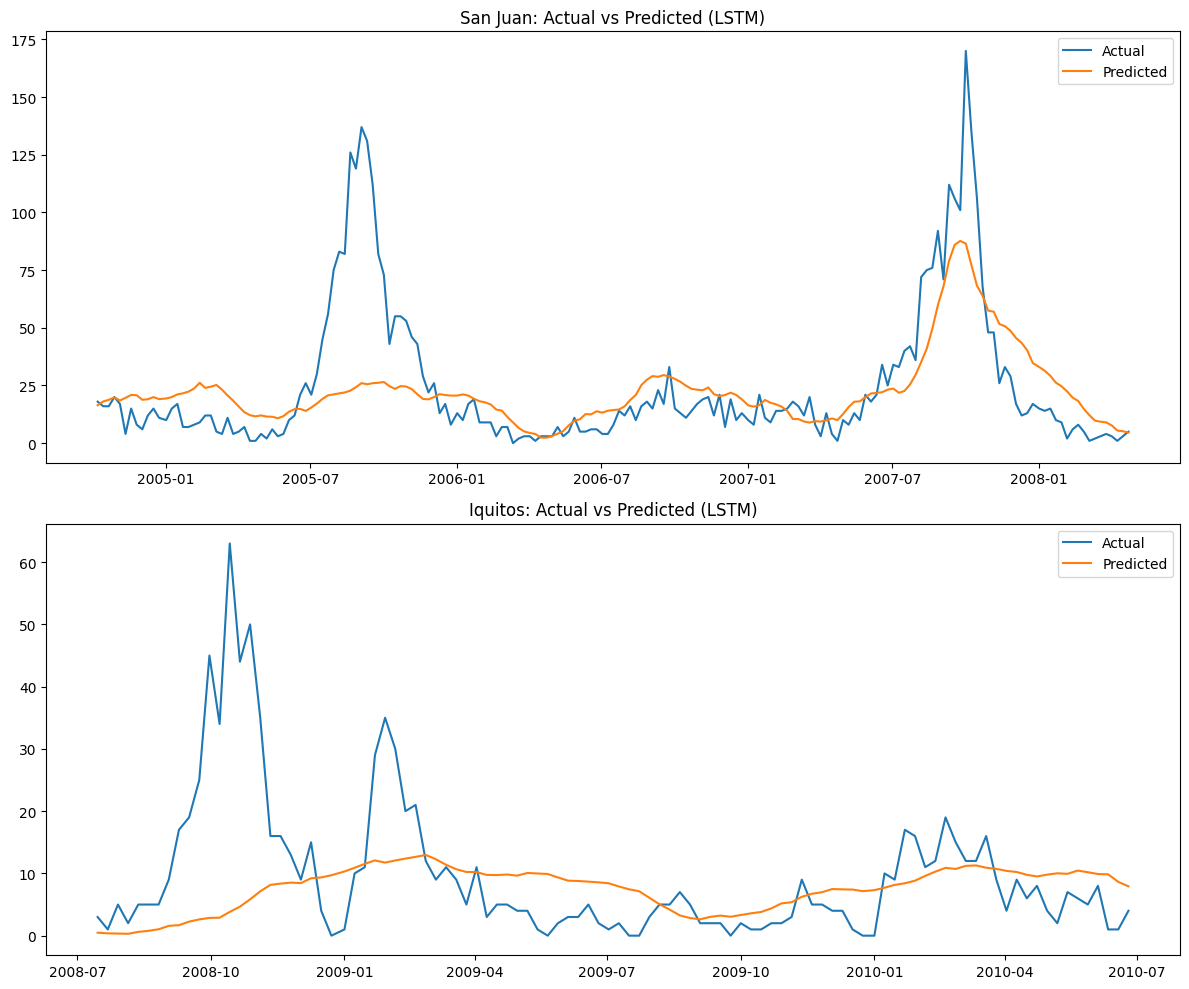

In [8]:
# EVALUATION

def evaluate_model(model, X_val, y_val_scaled, scaler_y, city_name):
    # Predict
    preds_scaled = model.predict(X_val)
    
    # Inverse transform
    preds = scaler_y.inverse_transform(preds_scaled)
    y_true = scaler_y.inverse_transform(y_val_scaled)
    
    # Ensure non-negative
    preds = np.maximum(preds, 0)
    
    # Calculate MAE
    mae = mean_absolute_error(y_true, preds)
    print(f"{city_name} MAE: {mae:.4f}")
    
    return y_true, preds

# Evaluate San Juan
y_true_sj, preds_sj = evaluate_model(model_sj, X_val_sj, y_val_sj, scaler_y_sj, "San Juan")

# Evaluate Iquitos
y_true_iq, preds_iq = evaluate_model(model_iq, X_val_iq, y_val_iq, scaler_y_iq, "Iquitos")

# Plot
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# San Juan
ax[0].plot(val_df_sj.index, y_true_sj, label='Actual')
ax[0].plot(val_df_sj.index, preds_sj, label='Predicted')
ax[0].set_title('San Juan: Actual vs Predicted (LSTM)')
ax[0].legend()

# Iquitos
ax[1].plot(val_df_iq.index, y_true_iq, label='Actual')
ax[1].plot(val_df_iq.index, preds_iq, label='Predicted')
ax[1].set_title('Iquitos: Actual vs Predicted (LSTM)')
ax[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# SUBMISSION

# 1. Load Test Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])
sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

# 2. Preprocess Test Data
sj_test = preprocess_city_data(sj_test_features)
iq_test = preprocess_city_data(iq_test_features)

def prepare_test_sequences(train_df, test_df, scaler_X, features_kept, seq_len=SEQ_LEN, rolling_weeks=ROLLING_WEEKS, lag_weeks=LAG_WEEKS):
    # 1. Combine Train Tail + Test to handle Rolling Features
    # We need enough history for the largest rolling window or lag
    max_rolling = max(rolling_weeks) if rolling_weeks else 0
    max_lag = max(lag_weeks) if lag_weeks else 0
    max_history = max(max_rolling, max_lag)
    
    # Add a buffer
    buffer = max_history + seq_len + 10
    
    train_subset = train_df.tail(buffer)
    
    # Ensure columns match (train might have extra columns if we didn't filter)
    # train_df has 'total_cases', test_df doesn't.
    # We only need feature columns.
    feature_cols = [c for c in train_df.columns if c != 'total_cases']
    
    # Note: train_df here is the original preprocessed df (sj_train), not the engineered one.
    # So it doesn't have rolling features yet.
    
    train_subset = train_subset[feature_cols]
    test_subset = test_df[feature_cols] # Should match
    
    combined = pd.concat([train_subset, test_subset])
    
    # 2. Feature Engineering
    combined_eng = add_engineered_features(combined, rolling_weeks=rolling_weeks, lag_weeks=lag_weeks)
    
    # 3. Filter Features (Pruning)
    # We must select exactly the same features as in training
    # features_kept contains the list of columns from training
    combined_eng = combined_eng[features_kept]
    
    # 4. Prepare for LSTM
    # We need to extract the part corresponding to Test, PLUS seq_len history
    # The test part starts after the train_subset part.
    # But wait, add_engineered_features drops NaNs.
    # The NaNs would be at the beginning of combined.
    # Since we added a buffer, the "test" part is safe.
    # We need to find where the test data starts.
    # We can use the index.
    
    # Identify test indices
    test_indices = test_df.index
    
    # We need the data from (start_of_test_index - seq_len) to end.
    # Let's find the integer location of the first test row in combined_eng
    # It's safer to just take the last (len(test_df) + seq_len) rows?
    # Yes, assuming combined_eng covers it.
    # We added buffer = max_history + seq_len + 10.
    # Rolling/Lags drops max_history rows (approx).
    # So we have plenty.
    
    required_len = len(test_df) + seq_len
    if len(combined_eng) < required_len:
        raise ValueError(f"Not enough history! Have {len(combined_eng)}, need {required_len}")
        
    data_for_seq = combined_eng.iloc[-required_len:]
    
    # 5. Scale
    X_scaled = scaler_X.transform(data_for_seq.values)
    
    # 6. Create Sequences
    # We want exactly len(test_df) sequences.
    xs = []
    for i in range(len(test_df)):
        # i=0: we want the sequence ending just before test_df[0]? 
        # No, to predict test_df[0], we need input X[0:SEQ_LEN] from data_for_seq.
        # data_for_seq has length SEQ_LEN + M.
        # i=0: slice 0:SEQ_LEN.
        xs.append(X_scaled[i : i + seq_len])
        
    return np.array(xs)

print("Generating Test Sequences...")
X_test_sj = prepare_test_sequences(sj_train, sj_test, scaler_X_sj, sj_features_kept, rolling_weeks=ROLLING_WEEKS, lag_weeks=LAG_WEEKS)
X_test_iq = prepare_test_sequences(iq_train, iq_test, scaler_X_iq, iq_features_kept, rolling_weeks=ROLLING_WEEKS, lag_weeks=LAG_WEEKS)

print("San Juan Test Input:", X_test_sj.shape)
print("Iquitos Test Input:", X_test_iq.shape)

# Predict
sj_preds_scaled = model_sj.predict(X_test_sj)
iq_preds_scaled = model_iq.predict(X_test_iq)

# Inverse Transform
sj_preds_final = scaler_y_sj.inverse_transform(sj_preds_scaled)
iq_preds_final = scaler_y_iq.inverse_transform(iq_preds_scaled)

# Clip and Round
sj_preds_final = np.maximum(sj_preds_final, 0).astype(int).flatten()
iq_preds_final = np.maximum(iq_preds_final, 0).astype(int).flatten()

# Create Submission
submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])
submission.loc['sj', 'total_cases'] = sj_preds_final
submission.loc['iq', 'total_cases'] = iq_preds_final

submission_path = os.path.join(WORKING_DIR, 'results', 'submission_lstm.csv')
submission.to_csv(submission_path)
print(f"Submission saved to {submission_path}")
submission.head()

Generating Test Sequences...
San Juan Test Input: (260, 20, 156)
Iquitos Test Input: (156, 20, 173)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Submission saved to C:/Users/malik.kalembasi/OneDrive - Odine Solutions/Desktop/itu/machine_learning/term_project\results\submission_lstm.csv


total_cases
city year weekofyear             
sj   2008 18                    3
          19                    3
          20                    4
          21                    4
          22                    6